<a href="https://colab.research.google.com/github/leandroaguazaco/data_science_portfolio/blob/main/Projects/04-Churn_Telco_Analysis/04_Churn_Telco_Analysis_04_explaining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> 4 - CHURN TELCO ANALYSIS </h1>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_project-true-blue">

</div>  

<h2 align="center"> 4.4 - Analyzing and Explaining Predictions </h2>

<div align="center">

  <img alt="Static Badge" src="https://img.shields.io/badge/active_section-true-blue">

  <img alt="Static Badge" src="https://img.shields.io/badge/section_status-in progress-green">

</div>  

<object
data="https://img.shields.io/badge/contact-Felipe_Leandro_Aguazaco-blue?style=flat&link=https%3A%2F%2Fwww.linkedin.com%2Fin%2Ffelipe-leandro-aguazaco%2F">
</object>

## a. Project summary

The aim of this project is to analyze and predict customer churn in the telco industry. The information pertains to client behavior, including in-call, out-call, and internet service consumption. There is a variable called 'Churn' that determines whether a customer churned within two weeks after canceling services. The information summarizes eight weeks of data for each telco line or client.

<h3 align="center"> <font color='orange'>NOTE: The project is distributed across multiple sections, separated into notebook files, in the following way:</font> </h3>



4.1 - Preprocessig data: load, join and clean data, and Exploratory data analysis, EDA.

4.2 - Premodeling: predict customer churn based on PyCaret library.

4.3 - Modeling: predict customer churn based on sklearn pipelines.

> <font color='gray'>  4.4 - Analyzing and explaining predictions, detecting vulneabilities in final machine learnig model. </font> ✍ ▶ <font color='orange'> Current section </font>

4.5 - Model deployment with Streamlit.

## b. Install libraries

In [1]:
%%capture
!pip install polars
!pip install pyjanitor # Clean DataFrame
!pip install colorama
!pip install adjustText
!pip install explainerdashboard
!pip install xgboost
!pip install lightgbm
!pip install catboost

!pip install shap
!pip install deepchecks

## c. Import libraries

In [2]:
%%capture
# c.1 Python Utilies
import pandas as pd
import polars as pl
import numpy as np
import math
import warnings
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from janitor import clean_names, remove_empty
from colorama import Fore, Style
import rpy2
import shutil
import os
import joblib
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%%capture
# c.2 Explaining machine learning model

# ML models
import xgboost as xgb
import lightgbm as lgb
import catboost as catb

# Explainer
from explainerdashboard import ClassifierExplainer, RegressionExplainer
from explainerdashboard import ExplainerDashboard

import shap

from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite

# Sklearn
    ### Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
    ### Preporcessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
    ### Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif # Univariate feature selection
    ### Metrics for classification
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, balanced_accuracy_score, recall_score, f1_score, jaccard_score ## Higher better
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# c.3 Setups
%matplotlib inline
plt.style.use("ggplot")
warnings.simplefilter("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## d. Custom functions

### d.1 - Type conversions

In [5]:
# d.1 dtypes conversion and memory reduce function.
def dtype_conversion(df: pd.DataFrame = None, verbose: bool = True)-> pd.DataFrame:
    """
    Summary:
      Function to dtypes conversion and save reduce memory usage; takes a DataFrame as argument, returns DataFrame.
      For more details, visit: https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd.
      The modifications include type casting for numerical and object variables.
    Parameters:
      df (pandas.DataFrame): DataFrame containing information.
      verbose (bool, default = True): If true, display results (conversions and warnings)
    Returns:
      pandas.DataFrame: original DataFrame with dtypes conversions
      Plot original dtypes status, variable warning due high cardinality, save memory usage, final dtypes status.
    """
    # 0- Original dtypes
    # print(Fore.GREEN + "Input dtypes" + Style.RESET_ALL)
    # print(df.dtypes)
    # print("\n")
    print(Fore.RED + "Higha Cardinality, categorical features with levels > 15" + Style.RESET_ALL)

    # 1- Original memory_usage in MB
    start_mem = df.memory_usage().sum() / 1024 ** 2

    # 2- Numerical Types
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int": # First 3 characters
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                #elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                #    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    # 3- Categorical Types
    high_card_vars = 0
    for col in df.select_dtypes(exclude = ["int8", "int16", "int32", "int64", "float16", "float32", "float64", "datetime64[ns]"]):
        categories = list(df[col].unique())
        cat_len = len(categories)
        if cat_len >= 2 and cat_len < 15:
           df[col] = df[col].astype("category")
        else:
          high_card_vars =+ 1
          # Print hight cardinality variables, amount of levels and a sample of 50 firts categories
          print(f"Look at: {Fore.RED + col + Style.RESET_ALL}, {cat_len} levels = {categories[:50]}")
    if high_card_vars == 0:
      print(Fore.GREEN + "None" + Style.RESET_ALL)
    else:
      pass

    # 4- Final memory_usage in MB
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("\n")
        print(f"{Fore.RED}Initial memory usage: {start_mem:.2f} MB{Style.RESET_ALL}")
        print(f"{Fore.BLUE}Memory usage decreased to {end_mem:.2f} MB ({ 100 * (start_mem - end_mem) / start_mem:.1f}% reduction){Style.RESET_ALL}")
        #print("\n")
        #print(Fore.GREEN + "Output dtypes" + Style.RESET_ALL)
        #print(df.dtypes)
        print("\n")

    # 5. Feature types
    print(Fore.GREEN + "Variable types" + Style.RESET_ALL)
    numerical_vars = len(df.select_dtypes(include = ["number"]).columns)
    categorical_vars = len(df.select_dtypes(include = ["category", "object"]).columns)
    datetime_vars = len(df.select_dtypes(include = ["datetime64[ns]"]).columns)
    print(f"Numerical Features: {numerical_vars}")
    print(f"Categorical Features: {categorical_vars}")
    print(f"Datetime Features: {datetime_vars}")

    return df

## 1 - Load data

In [6]:
# 1.1 - Import manin file from Google drive

# Mount Google Drive
drive.mount('/content/drive')


# Specify the source path in Google Drive
drive_filepath = '/content/drive/MyDrive/DataScience_Portfolio/04-Churn_Telco_Analysis/'

# Specify the destination path in Colab
colab_filepath = '/content/'

# Copy the file from Google Drive to Colab
try:
  shutil.copy(src = drive_filepath + '/churn_data.txt', dst = colab_filepath + '/churn_data.txt')
except:
  pass

Mounted at /content/drive


In [7]:
%%time
# 1.2 - Load data
#.drop_nulls() \
churn_df = pl.read_csv(source = 'churn_data.txt',
                       has_header = True,
                       separator = "|",
                       try_parse_dates = True,
                       encoding = "utf8") \
             .drop(columns = ["SUBSCRIBER_ID"]) \
             .drop_nulls(subset = ['churn']) \
             .with_columns(pl.col(['region', 'churn', 'canal', 'bandas', 'tipo_gross_adds']).cast(pl.Categorical)) \
             .to_pandas() \
             .pipe(dtype_conversion)
print("\n")

Higha Cardinality, categorical features with levels > 15
Look at: region, 34 levels = ['Bogota D.C.', 'Santander', 'Antioquia', nan, 'Cundinamarca', 'Quindio', 'Valle Del Cauca', 'Arauca', 'Bolivar', 'Atlantico', 'Tolima', 'Huila', 'Meta', 'Putumayo', 'Boyaca', 'Caldas', 'Cordoba', 'Nariño', 'Magdalena', 'Risaralda', 'Cauca', 'La Guajira', 'Norte De Santander', 'Caqueta', 'Cesar', 'Guaviare', 'Sucre', 'Amazonas', 'Guainia', 'Vichada', 'Choco', 'Casanare', 'Providencia Islas', 'Vaupes']


Initial memory usage: 175.54 MB
Memory usage decreased to 87.48 MB (50.2% reduction)


Variable types
Numerical Features: 38
Categorical Features: 5
Datetime Features: 0


CPU times: user 3.42 s, sys: 1.6 s, total: 5.02 s
Wall time: 3.77 s


## 2 - Estimators

In [16]:
# Calculate the class imbalance ratio based on  XGBoostClassifier
# https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
positive_samples = sum(y_train.loc[:, 'churn'] == 1)
negative_samples = sum(y_train.loc[:, 'churn'] == 0)
imbalance_ratio = (negative_samples / positive_samples)

### LightGBM Classifier

In [17]:
lgb_model = lgb.LGBMClassifier(scale_pos_weight = imbalance_ratio, # Like in XGBoostClassifier
                               colsample_bytree =  0.7211947114503046,
                               learning_rate = 0.19556253301804158,
                               max_depth = 7,
                               min_child_samples = 71,
                               min_child_weight = 0.2689381814201991,
                               min_split_gain = 0.0018357730892767825,
                               n_estimators = 139 ,
                               num_leaves = 43,
                               reg_alpha = 0.3102209158407799,
                               reg_lambda = 0.11062167179280916,
                               subsample = 0.8182872702293318)

### Logistic Regression

In [ ]:
lgr_model = LogisticRegression(class_weight = 'balanced',
                               n_jobs = -1,
                               C = 65,
                               l1_ratio = 0.2439194500163286,
                               max_iter = 810,
                               tol = 0.014348835802278966)

## 3 - Pipeline

### 3.1 - Variable types

In [8]:
# Variables types

# Target feature
target_var = ["churn"]

# Datetime features
datetime_vars = churn_df.select_dtypes(include = "datetime64[ns]").columns.tolist()

# Numerical features
numerical_vars = churn_df.select_dtypes(include = "number").columns.tolist()

# Categorical features
nominal_vars = churn_df.select_dtypes(include = "category").columns.tolist()
nominal_vars.pop(-1) # Exclude target variable, instantiated above

# 2.2 Reorder DataFrame
new_col_order = target_var + numerical_vars + nominal_vars
churn_df = churn_df.reindex(columns = new_col_order)

In [9]:
len(churn_df.columns)

43

### 3.2 - Train - Test split

In [10]:
# Target and independent variables
X = churn_df.copy(deep = True).drop(labels = ["churn"], axis = 1)
y = churn_df.copy(deep = True).loc[:, "churn"]

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.80,
                                                    test_size = 0.20,
                                                    stratify = y,
                                                    random_state = 123456)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(476530, 42) (119133, 42) (476530,) (119133,)


### 3.3 - Encoding target variable

In [12]:
# 1. Instantiate Encoder
target_encoder = LabelEncoder()

# 2. y train encoder
y_train_encoded = target_encoder.fit_transform(y_train)
print(target_encoder.classes_)
y_train = pd.DataFrame(data = y_train_encoded, columns = ["churn"])
print(y_train.head())

# 3.3 y test encoder
y_test_encoded = target_encoder.transform(y_test)
y_test = pd.DataFrame(data = y_test_encoded, columns = ['churn'])
print(y_test.head())

['No' 'Sí']
   churn
0      0
1      0
2      0
3      0
4      1
   churn
0      0
1      0
2      0
3      0
4      0


### 3.4 - Nominal Pipeline

In [13]:
nominal_pipeline = make_pipeline(
    # 1. Nominal encoder
    OneHotEncoder(categories = "auto",
                  drop = "first", # "first" or "None", Specifies a methodology to use to drop one of the categories per feature
                  sparse_output = False,
                  dtype = "float", # Desired dtype of output
                  handle_unknown = 'infrequent_if_exist',
                  min_frequency = 0.03,
                  max_categories = 30),
)

nominal_pipeline

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='first', dtype='float',
                               handle_unknown='infrequent_if_exist',
                               max_categories=30, min_frequency=0.03,
                               sparse_output=False))])

### 3.5 - Transformers

In [14]:
# 1 Combine ordinal and nominal pipelines
transformations = ColumnTransformer(
    transformers=[("numerical", "passthrough", numerical_vars), # No transformation required for numerical variables
                  # ("ordinal", ordinal_pipeline, ordinal_vars), # No ordinal data
                  ("nominal", nominal_pipeline, nominal_vars)],
    #remainder = 'passthrough'
)

### 3.6 - Pipeline

In [18]:
# Full pipeline original

full_pipeline = make_pipeline(
    # 1. Numerical and categorical (nominal + ordinal) transformers
    transformations,

    # 2. Impute missing values
    IterativeImputer(estimator = BayesianRidge(),
                     max_iter = 10,
                     random_state = 123456),

    # 3. Feature selector that removes all low-variance features
    VarianceThreshold(threshold = 0.1),

    # 4. Imbalance sampling

    # 5. Scale features
    RobustScaler(with_centering = True,
                 with_scaling = True,
                 quantile_range = (25.0, 75.0),
                 copy = True,
                 unit_variance = False),

    # 6. Transform features
    PowerTransformer(method = 'yeo-johnson',
                     standardize = True,
                     copy = True),

    # 7. Dimensionality reduction
    # PCA(n_components = 'mle'),
    # UMAP(n_components = 5),

    # 8. Feature selection: univariate feature selection ~ 50% of features
    SelectKBest(score_func = f_classif, k = 23),

    # 9. Classifier
    lgb.LGBMClassifier(scale_pos_weight = imbalance_ratio, # Like in XGBoostClassifier
                       colsample_bytree =  0.7211947114503046,
                       learning_rate = 0.19556253301804158,
                       max_depth = 7,
                       min_child_samples = 71,
                       min_child_weight = 0.2689381814201991,
                       min_split_gain = 0.0018357730892767825,
                       n_estimators = 139 ,
                       num_leaves = 43,
                       reg_alpha = 0.3102209158407799,
                       reg_lambda = 0.11062167179280916,
                       subsample = 0.8182872702293318)

    # 10. Memory cache
    #memory = memory
)

full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['cant_sem_datos',
                                                   'prom_gb_tt', 'prom_gb_ran',
                                                   'prom_%_propia',
                                                   'continuidad_traf',
                                                   'variacion_datos_8s',
                                                   'cons_ult_sem', 'contrafico',
                                                   'mean_minutos_voz_in',
                                                   'mean_llamadas_in',
                                                   'mean_llamadas_in_num_dif',
                                                   'mean_porcent_llamadas_fallidas_in',
                                                   'mean_porcent_minutos...
                 LGBMClassifier(colsample_bytree=0.7211947114503046,
                                learning_rate=0.19556253301804158, max_depth=7,
                                min_child_samples=71,
                                min_child_weight=0.2689381814201991,
                                min_split_gain=0.0018357730892767825,
                                n_estimators=139, num_leaves=43,
                                reg_alpha=0.3102209158407799,
                                reg_lambda=0.11062167179280916,
                                scale_pos_weight=29.175405268490376,
                                subsample=0.8182872702293318))])

### 3.7 - Fit model

In [24]:
full_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 15792, number of negative: 460738
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4834
[LightGBM] [Info] Number of data points in the train set: 476530, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033140 -> initscore=-3.373326
[LightGBM] [Info] Start training from score -3.373326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['cant_sem_datos',
                                                   'prom_gb_tt', 'prom_gb_ran',
                                                   'prom_%_propia',
                                                   'continuidad_traf',
                                                   'variacion_datos_8s',
                                                   'cons_ult_sem', 'contrafico',
                                                   'mean_minutos_voz_in',
                                                   'mean_llamadas_in',
                                                   'mean_llamadas_in_num_dif',
                                                   'mean_porcent_llamadas_fallidas_in',
                                                   'mean_porcent_minutos...
                 LGBMClassifier(colsample_bytree=0.7211947114503046,
                                learning_rate=0.19556253301804158, max_depth=7,
                                min_child_samples=71,
                                min_child_weight=0.2689381814201991,
                                min_split_gain=0.0018357730892767825,
                                n_estimators=139, num_leaves=43,
                                reg_alpha=0.3102209158407799,
                                reg_lambda=0.11062167179280916,
                                scale_pos_weight=29.175405268490376,
                                subsample=0.8182872702293318))])

In [ ]:
# Export pipeline including classifier
joblib.dump(full_pipeline, 'lightgbm_pipeline.pkl')

['lightgbm_pipeline.pkl']

In [ ]:
# Load the pipeline from the file
lightgbm_pipeline = joblib.load('lightgbm_pipeline.pkl')

## 4 - SHAP values

In [ ]:
# 1. Transform trainig data
X_train_tranf = full_pipeline[:-1].transform(X_train)

# Extract feature names
feature_names = [i[i.find("_") + 2:] for i in full_pipeline.named_steps['columntransformer'].get_feature_names_out().tolist()]
mask = [int(i.strip("x")) for i in full_pipeline.named_steps['selectkbest'].get_feature_names_out()]
feature_names = [feature_names[i] for i in mask]
feature_names

# Transformed X test to pandas
X_train_tranf = pd.DataFrame(data = X_train_tranf,
                             columns = feature_names)

In [ ]:
# 2. Explainer
explainer = shap.Explainer(full_pipeline.steps[-1][1])

In [ ]:
# 3. Shap values
shap_values = explainer(X_train_tranf)

In [ ]:
print(shap_values.values.shape)

(471916, 23, 2)


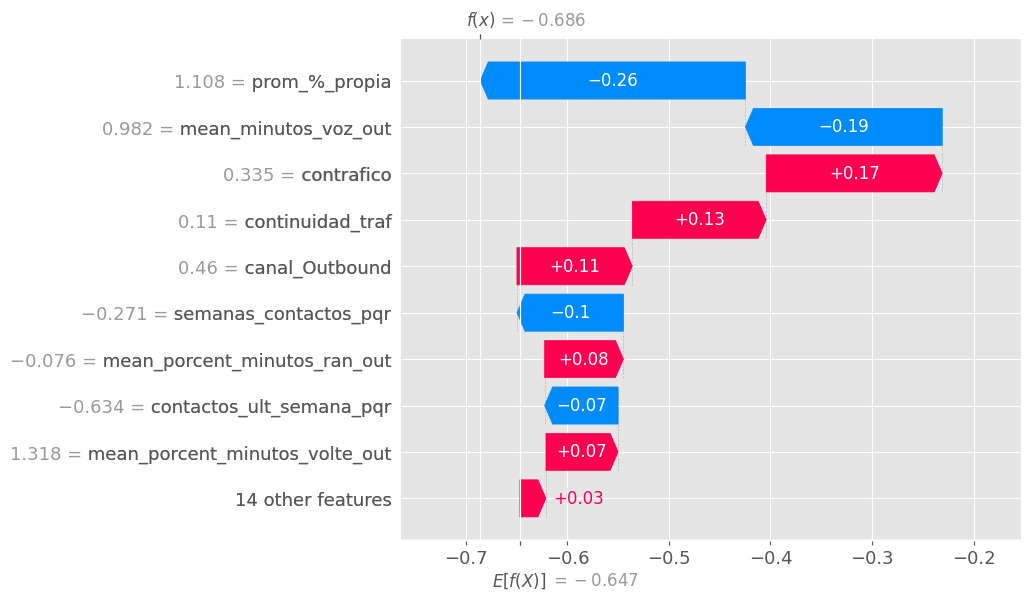

In [ ]:
shap.plots.waterfall(shap_values[0, :, 1])

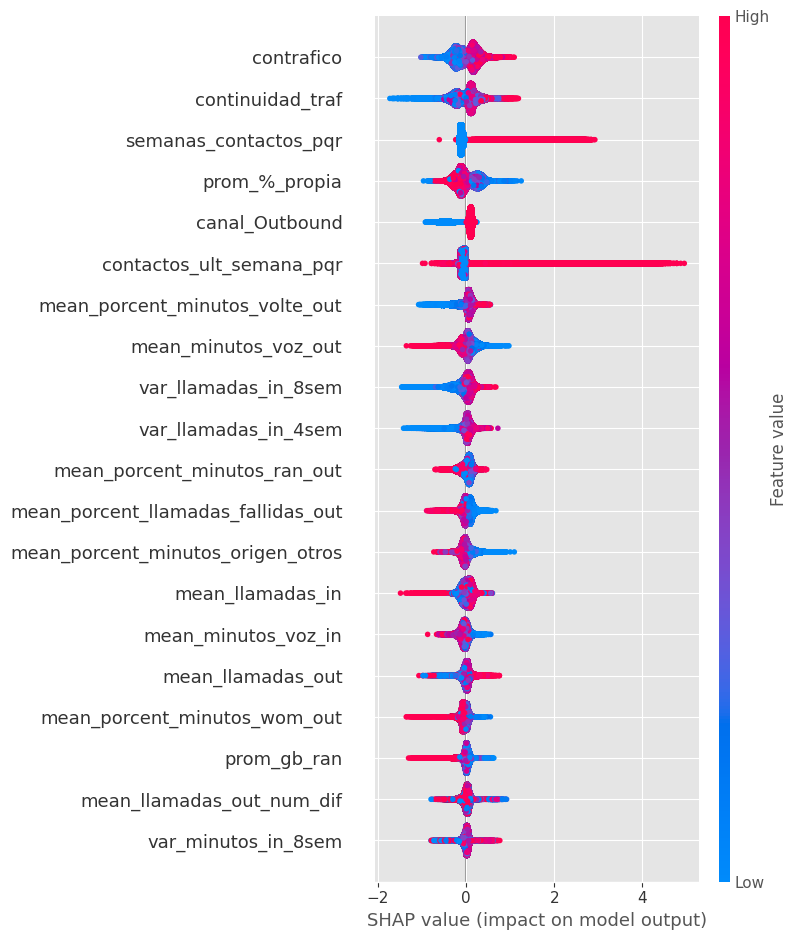

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_train_tranf)

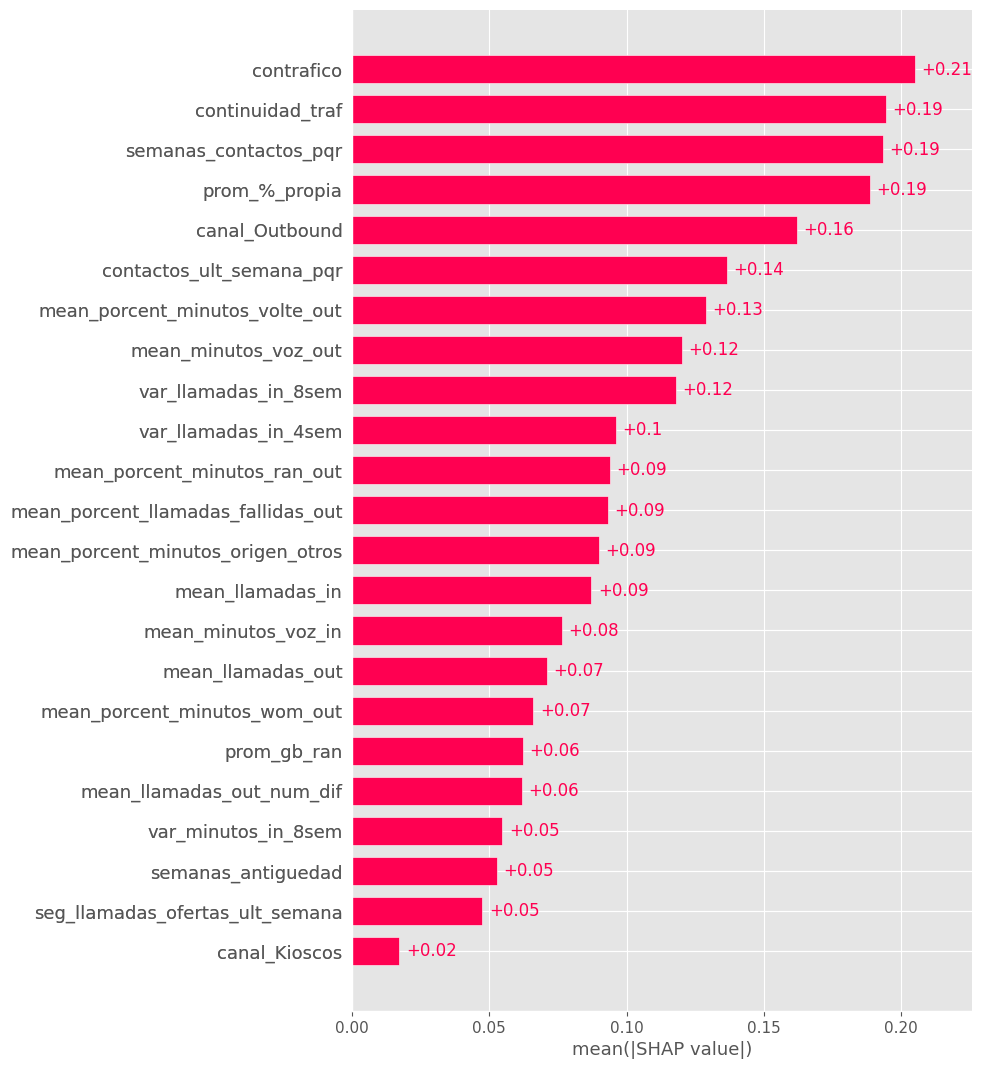

In [ ]:
shap.plots.bar(shap_values[:, :, 1], max_display = 23)

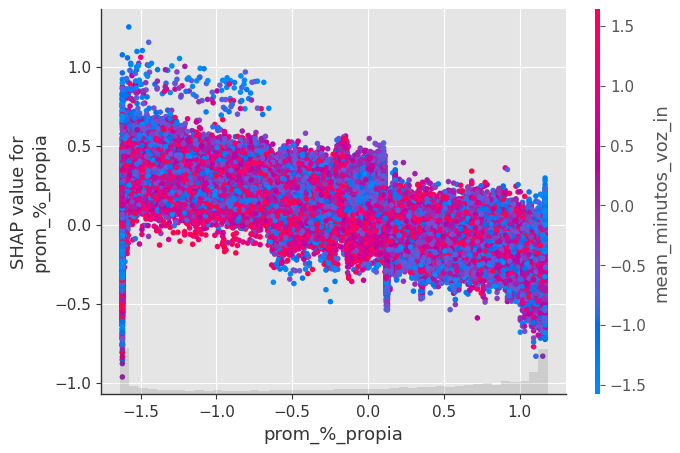

In [ ]:
shap.plots.scatter(shap_values[:, 1, 1], color = shap_values[:, 4, 1])

In [ ]:
# Get interaction values
shap_interaction_values = explainer.shap_interaction_values(X_train_tranf)
shap.summary_plot(shap_interaction_values, X_train_tranf)

## 5 - Deepchecks library

In [21]:
# 0. Train test split
X_train_check, X_test_check = train_test_split(churn_df,
                                               train_size = 0.80,
                                               test_size = 0.20,
                                               stratify = churn_df["churn"],
                                               random_state = 123456)

In [22]:
# 1. Transform training a testing datasets function:

def tranforming_data(df: pd.DataFrame = None, target: str = None) -> pd.DataFrame:
  """
  Summary:
    Function that apply sklearn pipeline to dataframe. It requires a fitted pipeline.
  Parameters:
    df (pd.DataFrame, default = None): DataFrame.
    targe (string, default = None): target variable.
  Return:
    pandas DataFrame, transforming data
  """
  # Extract target variable
  target = pd.DataFrame(data = X_train_check.copy(deep = True).loc[:, target], columns = [target]) \
             .sort_index() \
             .reset_index(drop = True)

  # Transform trainig data
  df_tranf = full_pipeline[:-1].transform(df.sort_index().reset_index(drop = True))

  # Extract feature names
  feature_names = [i[i.find("_") + 2:] for i in full_pipeline.named_steps['columntransformer'].get_feature_names_out().tolist()]
  mask = [int(i.strip("x")) for i in full_pipeline.named_steps['selectkbest'].get_feature_names_out()]
  feature_names = [feature_names[i] for i in mask]
  feature_names

  # Transformed X test to pandas
  df_tranf = pd.DataFrame(data = df_tranf,
                          columns = feature_names)

  # Join predictors and target
  df_tranf = pd.concat([df_tranf, target],
                        axis = 1,
                        join = 'outer',
                        ignore_index = False)
  return df_tranf

In [25]:
# 2. Tranforming data
X_train_check = tranforming_data(df = X_train_check, target = 'churn')
X_test_check = tranforming_data(df = X_test_check, target = 'churn')

print(X_train_check.shape, X_test_check.shape)

(476530, 24) (476530, 24)


In [26]:
# 3. Fit uniquelly model, no use sklearn pipeline

lgb_model.fit(X_train_check.drop(labels = ['churn'], axis = 1),
              X_train_check.loc[:, 'churn'])

[LightGBM] [Info] Number of positive: 15792, number of negative: 460738
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4833
[LightGBM] [Info] Number of data points in the train set: 476530, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033140 -> initscore=-3.373326
[LightGBM] [Info] Start training from score -3.373326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.7211947114503046,
               learning_rate=0.19556253301804158, max_depth=7,
               min_child_samples=71, min_child_weight=0.2689381814201991,
               min_split_gain=0.0018357730892767825, n_estimators=139,
               num_leaves=43, reg_alpha=0.3102209158407799,
               reg_lambda=0.11062167179280916,
               scale_pos_weight=29.175405268490376,
               subsample=0.8182872702293318)

In [27]:
# 4. Define a Dataset Object
ds_train = Dataset(X_train_check, label = 'churn', cat_features = [])
ds_test =  Dataset(X_test_check,  label = 'churn', cat_features = [])

In [29]:
# 5. Run a Deepchecks Suite
suite = full_suite()
suite.run(train_dataset = ds_train,
          test_dataset = ds_test,
          model = lgb_model)

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Full Suite